# Faces recognition  
Or faces classification using eigenfaces and SVM (Support Vector Machine) classification model. This excercise was made after online following Harvard's CS109 2015 Lecture 10 to gain some hands-on experience. Of course one could as well choose recognition of handwriting, license plates or road vehicles. The faces recognition is based on both the [Scikit-learn example](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html) as Dario Radecic' example in [Towards Datascience](https://towardsdatascience.com/eigenfaces-face-classification-in-python-7b8d2af3d3ea).  The latter one for its clear explanation.

In [1]:
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tarfile

## Example Scikit-learn
### Download and import data
The [faces dataset file](http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz) originates from [Labeled Faces in the Wild](vis-www.cs.umass.edu/lfw/). Due to its size of 233 MB (compressed) this file is not uploaded to GitHub. It can best be downloaded and unpacked locally using the cells below or manually if you like. Downloading and unpacking the dataset file is done just once to speed up later, multiple runs of faces recognition.

In [2]:
def dataURL():
    return('http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz')

In [3]:
def dataDirectory():
    return 'data/'

In [4]:
def dataFile():
    return dataDirectory() + 'lfw-funneled.tgz'

In [5]:
if not os.path.exists('data/lfw_funneled'):
    print('downloading...')
    zippedFacesFile = requests.get(dataURL())
    print('saving...')
    open(dataFile(), 'wb').write(zippedFacesFile.content)
    print('unpacking...')
    tf = tarfile.open(dataFile())
    tf.extractall(path=dataDirectory())
    print('done')
    tf.close()

In [6]:
#scikit-learn has a special read operation for lfw files
lfw_people=fetch_lfw_people(data_home=dataDirectory() + 'lfw_funneled', min_faces_per_person=70)

### Exploratory data analysis


In [7]:
#DESCR description of the Labeled Faces in the Wild (LFW) dataset
print(lfw_people.DESCR)

.. _labeled_faces_in_the_wild_dataset:

The Labeled Faces in the Wild face recognition dataset
------------------------------------------------------

This dataset is a collection of JPEG pictures of famous people collected
over the internet, all details are available on the official website:

    http://vis-www.cs.umass.edu/lfw/

Each picture is centered on a single face. The typical task is called
Face Verification: given a pair of two pictures, a binary classifier
must predict whether the two images are from the same person.

An alternative task, Face Recognition or Face Identification is:
given the picture of the face of an unknown person, identify the name
of the person by referring to a gallery of previously seen pictures of
identified persons.

Both Face Verification and Face Recognition are tasks that are typically
performed on the output of a model trained to perform Face Detection. The
most popular model for Face Detection is called Viola-Jones and is
implemented in the OpenC

In [8]:
#DATA features X
X=lfw_people.data
print(X.shape)
#TARGET y; the label to predict is the id of the person
y=lfw_people.target
print(y.shape)
#IMAGES
n_samples, pixel_height, pixel_width = lfw_people.images.shape #multiple assignment
print (n_samples, pixel_height, pixel_width)
#target names
target_names=lfw_people.target_names
print(target_names)
#nr of people in target
n_people=target_names.size
print(n_people)

(1288, 2914)
(1288,)
1288 62 47
['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
7


### Image visualization
To visualize a couple of faces we’ll declare a function which transforms 1D vector to a 2D matrix, and uses Matplotlib’s imshow functionality to show it as a grayscale image<br><br>
The `plot_faces()` function is used in the Scikit-learn and the Towards Datascience examples.

In [9]:
def plot_faces(pixels, titles=[], n_rows=4, n_columns=4):
    fig, axes = plt.subplots(n_rows, n_columns, figsize=(16, 16))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[i].reshape(pixel_height, pixel_width), cmap='gray')
        if len(titles) != 0:
            ax.set_title(titles[i])
    plt.show()

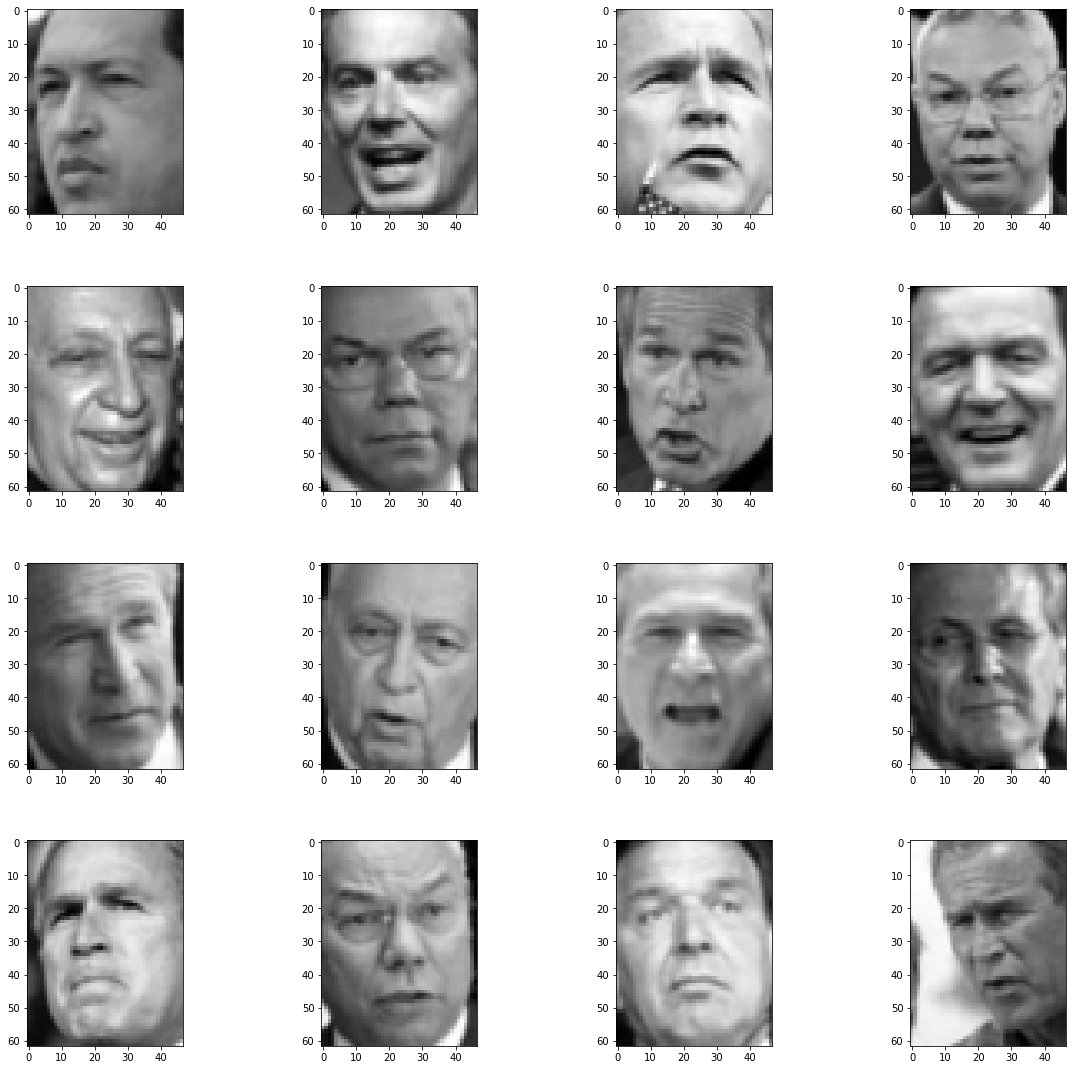

In [10]:
plot_faces(X)

### Principal Component Analysis
Or PCA. The goal is reducing dimensionality. This is done by keeping the components that explain most of the cumulative variance. 

In [11]:
# Split into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) #default test_size=0.25

In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(966, 2914)
(966,)
(322, 2914)
(322,)


In [13]:
# Compute a Principal Component Analysis PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): 
# unsupervised feature extraction / dimensionality reduction
pca = PCA().fit(X_train)
pca.components_.size

2814924

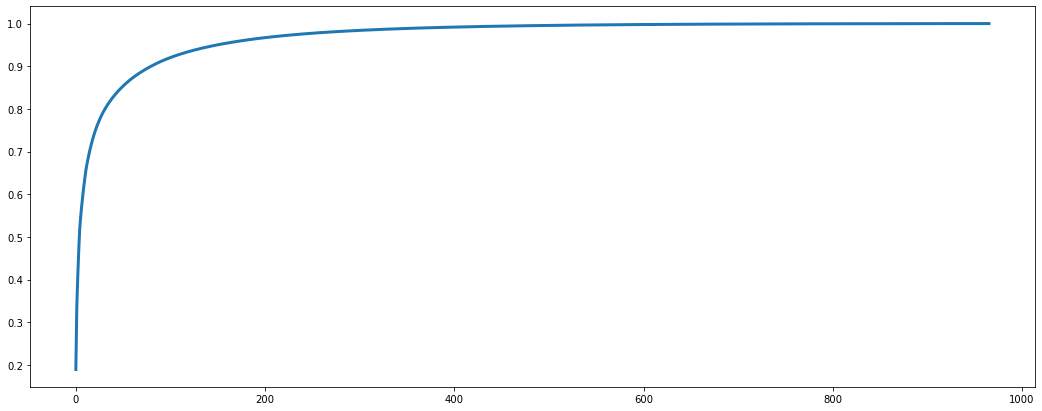

In [14]:
#plot the cumulative sum of the explained variance, so we can approximate how many principal components are enough
plt.figure(figsize=(18, 7))
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [15]:
np.where(pca.explained_variance_ratio_.cumsum() > 0.95)
print(X_train.shape[0])

966


In [16]:
# taking 150 eigenfaces from 966 faces
n_components=150 
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)
print(pca.components_.size)
eigenfaces=pca.components_

437100


In [17]:
# Projecting the input data on the eigenfaces orthonormal basis
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### Train a SVM classification model
The kernel function used here is Radial basis function (RBF). The polynomial function `poly` might also be tested. Exponential sequences are used for the param grid.

In [18]:
# Train a Support Vector Machine (SVM) classification model
params={'C': [1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1] }
clf=GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), params)
# fit classifier model to training data
clf = clf.fit(X_train_pca, y_train)
# best grid search estimator
clf.best_estimator_

SVC(C=1000.0, class_weight='balanced', gamma=0.005)

In [19]:
#Fit the classifier to the training set
clf = SVC().fit(X_train_pca, y_train)

In [20]:
y_predictions = clf.predict(X_test_pca)
print(classification_report(y_test, y_predictions, target_names=target_names)) #predict names on the testset

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.38      0.56        13
     Colin Powell       0.87      0.87      0.87        60
  Donald Rumsfeld       1.00      0.44      0.62        27
    George W Bush       0.71      0.98      0.82       146
Gerhard Schroeder       1.00      0.60      0.75        25
      Hugo Chavez       1.00      0.33      0.50        15
       Tony Blair       1.00      0.67      0.80        36

         accuracy                           0.80       322
        macro avg       0.94      0.61      0.70       322
     weighted avg       0.84      0.80      0.78       322



In [21]:
print(confusion_matrix(y_test, y_predictions, labels=range(n_people)))

[[  5   2   0   6   0   0   0]
 [  0  52   0   8   0   0   0]
 [  0   1  12  14   0   0   0]
 [  0   3   0 143   0   0   0]
 [  0   0   0  10  15   0   0]
 [  0   1   0   9   0   5   0]
 [  0   1   0  11   0   0  24]]


In [22]:
title_names=[]
for i in range(y_predictions.shape[0]):
    real_name=target_names[y_test[i]]
    predicted_name=target_names[y_predictions[i]]
    title_name= 'real: %s\npred: %s' % (real_name, predicted_name)
    title_names.append(title_name)

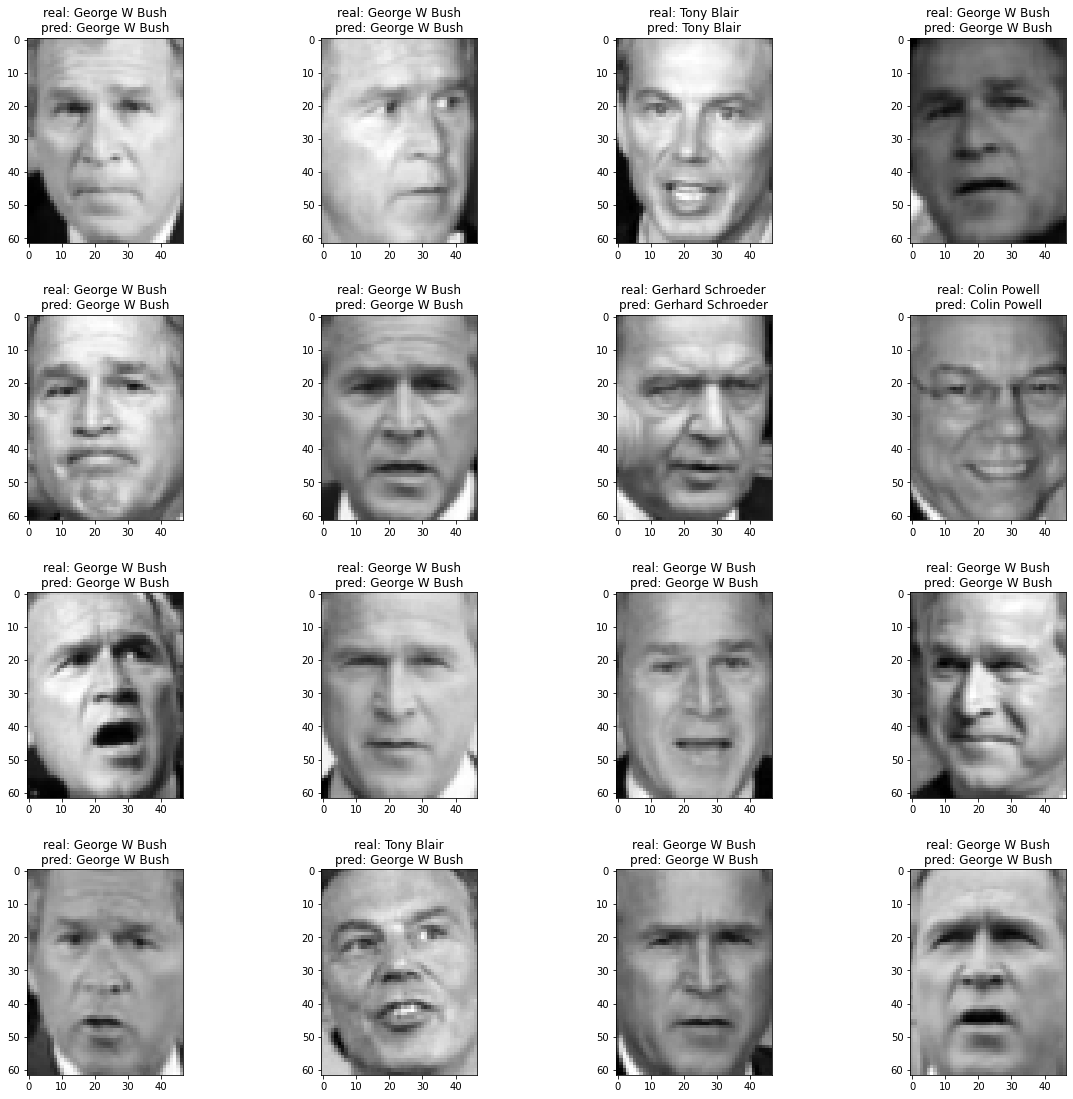

In [23]:
plot_faces(X_test, title_names)

In [24]:
title_eigenfaces=[]
for i in range(eigenfaces.shape[0]):
    title_eigenface='eigenface ID %d' % (i)
    title_eigenfaces.append(title_eigenface)

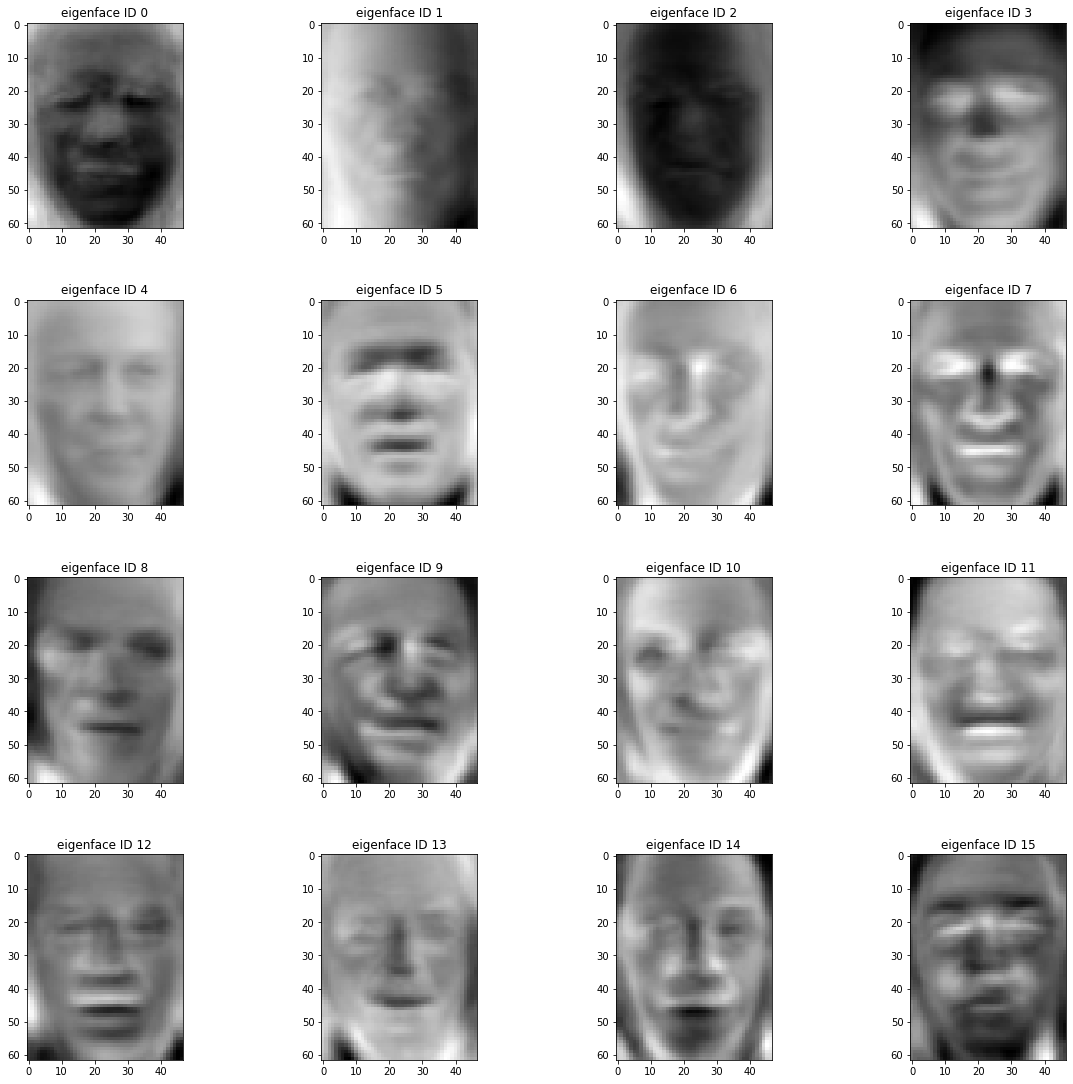

In [25]:
plot_faces(eigenfaces, title_eigenfaces)

## Example Towards Datascience
### Download and import data

In [26]:
def dataCsvURL():
    return 'https://raw.githubusercontent.com/daradecic/Python-Eigenfaces/master/face_data.csv'

In [27]:
def dataDirectory():
    return 'data/'

In [28]:
def dataCsvFile():
    return dataDirectory() + 'face_data.csv'

In [29]:
#Let's give it a try and save to CSV file
if not os.path.exists('data/face_data.csv'):
    facesFile = requests.get(dataCsvURL())
    open(dataCsvFile(), 'wb').write(facesFile.content)
    print("Saving to ", dataCsvFile())

In [30]:
df = pd.read_csv(dataCsvFile())
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


In [31]:
df.shape

(400, 4097)

In [32]:
df.target.nunique()

40

In [34]:
pixel_height = pixel_width = int(4096**(1/2))
print (pixel_height, pixel_width)

64 64


In [35]:
# the label to predict is the id of the person
y = df.target
y.shape

(400,)

In [36]:
# features
X = df.drop('target', axis=1)
X.shape

(400, 4096)

In [37]:
# Split into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42) #default test_size=0.25

In [38]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(300, 4096)
(300,)
(100, 4096)
(100,)


In [39]:
# Compute a Principal Component Analysis PCA (eigenfaces) on the face dataset (treated as unlabeled dataset): 
# unsupervised feature extraction / dimensionality reduction
pca = PCA().fit(X_train)
pca.components_.size

1228800

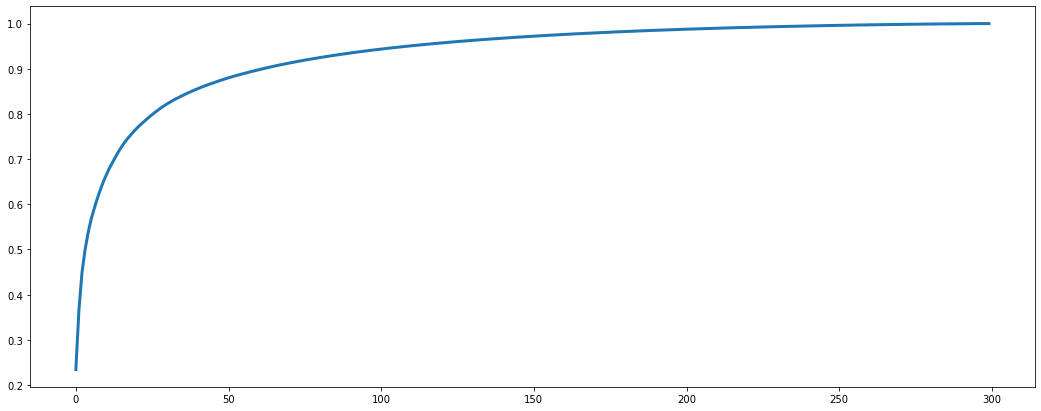

In [40]:
plt.figure(figsize=(18, 7))
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [41]:
np.where(pca.explained_variance_ratio_.cumsum() > 0.95)
print(X_train.shape[0])

300


In [42]:
# taking 150 eigenfaces
n_components=150 
pca = PCA(n_components=n_components).fit(X_train)
print(pca.components_.size)
eigenfaces=pca.components_

614400


In [43]:
# Projecting the input data on the eigenfaces orthonormal basis
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [44]:
clf = SVC().fit(X_train_pca, y_train)

In [45]:
y_predictions = clf.predict(X_test_pca)
print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         4
           4       0.60      1.00      0.75         3
           5       1.00      1.00      1.00         3
           6       1.00      1.00      1.00         1
           7       1.00      0.57      0.73         7
           8       1.00      1.00      1.00         2
           9       0.75      1.00      0.86         3
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         3
          15       1.00      1.00      1.00         2
          16       0.00      0.00      0.00         0
          17       1.00    

C:\Users\Rodzinka\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Rodzinka\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
set(y_test) - set(y_predictions) #hmm, just 34 caused the warning

{34}

In [46]:
y_predictions.shape[0]

100

In [47]:
print(confusion_matrix(y_test, y_predictions))

[[2 0 0 ... 0 0 1]
 [0 2 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 2]]
